## Jupyter notebook for plotting the log2 foldchange between CHi-C, ATAC-seq and RNA-seq

This notebook is the code for plotting the log2 folchange between CHi-C, ATAC-seq and RNA-seq time course data (Fig. 4b,c) used in the paper **"Simultaneous analysis of open chromatin, promoter interactions and gene expression in stimulated T cells implicates causal genes for rheumatoid arthritis"** by Jing Yang, Amanda McGovern, Paul Martin, Kate Duffus, Peyman Zarrineh, Andrew P Morris, Antony Adamson, Peter Fraser, Magnus Rattray & Stephen Eyre 

Author : *Jing Yang*  <br />
Date: 24-10-2019 <br />
For any questions about the code, please drop me a line at Jing.Yang@manchester.ac.uk

### load required packages

In [1]:
library(ggplot2)
library(DESeq2)
#library(ggpubr)
#library(gridExtra)
#library(latex2exp)


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min



Attaching package: ‘S4Vectors’


The

### load linked gene expression, open chromatin and interaction data.

In [2]:
data <- read.table(file='data/CHiC_ATACseq_RNAseq_linked_within5MB.txt', header=T)

### get data with dynamic ATACseq

In [3]:
data_dynamic_atacseq <- data[data$Alld_ratio0<0,]

In [4]:
dim(data_dynamic_atacseq)

[1] 11554    19

### load these highly correlated links

In [5]:
data_corrover0.5 <- read.table('data/CHiC_ATACseq_RNAseq_linked_correlationover0.5.txt', header=T)

### load raw reads ATAC-seq, RNA-seq and CHi-C data

In [6]:
counts_chic <- read.table('data/CHiC_counts.txt', header=T)
counts_gene <- read.table('data/RNAseq_counts.txt', header=T)
counts_atacseq <- read.table('data/ATACseq_counts.txt', header=T)

### calculating log2 foldchange by DESeq2

In [7]:
counts_chic_0and24 <- as.matrix(counts_chic[,c('T01','T02','T24H1')])
counts_gene_0and24 <- as.matrix(counts_gene[,c('O0','N0','O24H','N24H')])
counts_atacseq_0and24 <- as.matrix(counts_atacseq[,c('T01','T02','T03','T24H1','T24H2','T24H3')])

coldata_chic <- data.frame(condition = c('1','2','1'), replicate=c('T0','T0','T24H'))
rownames(coldata_chic) <- names(counts_chic_0and24)
dds_chic <- DESeqDataSetFromMatrix(countData = counts_chic_0and24,
                              colData = coldata_chic,
                              design = ~ replicate)
dds_chic <- DESeq(dds_chic)
res_chic <- results(dds_chic)

coldata_gene <- data.frame(condition = c('1','2','1','2'), replicate=c('T0','T0','T24H','T24H'))
rownames(coldata_gene) <- names(counts_gene_0and24)

dds_gene <- DESeqDataSetFromMatrix(countData = counts_gene_0and24,
                              colData = coldata_gene,
                              design = ~ replicate)
dds_gene <- DESeq(dds_gene)
res_gene <- results(dds_gene)


coldata_atacseq <- data.frame(condition = c('1','2','3','1','2','3'), replicate=c('T0','T0','T0','T24H','T24H','T24H'))
rownames(coldata_atacseq) <- names(counts_atacseq_0and24)
dds_atacseq <- DESeqDataSetFromMatrix(countData = counts_atacseq_0and24,
                              colData = coldata_atacseq,
                              design = ~ replicate)
dds_atacseq <- DESeq(dds_atacseq)
res_atacseq <- results(dds_atacseq)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [8]:
chic_log2foldchange <- as.data.frame(cbind(counts_chic[,c('baitID','otherEndID')], res_chic$log2FoldChange))
gene_log2foldchange <- as.data.frame(cbind(as.character(counts_gene[,'ENSG']), res_gene$log2FoldChange))
atacseq_log2foldchange <- as.data.frame(cbind(counts_atacseq[,c('seqnames','start','end')], res_atacseq$log2FoldChange))


In [9]:

names(chic_log2foldchange) <- c('baitID','otherEndID','chic_log2foldchange')
names(gene_log2foldchange) <- c('ENSG','gene_log2foldchange')
names(atacseq_log2foldchange) <- c('ATACchr','ATACstart','ATACend','atacseq_log2foldchange')

### plot the results

In [10]:
linked_ID_chic_gene <- unique(data_dynamic_atacseq[,c('baitID','otherEndID','ENSG')])
merged_data <- unique(merge(merge(chic_log2foldchange, linked_ID_chic_gene), gene_log2foldchange))

merged_data_clean <- merged_data[complete.cases(merged_data),]

ID_corrover0.5 <- unique(data_corrover0.5[,c('baitID','otherEndID','ENSG')])

result_merged_corrover0.5 <- merge(ID_corrover0.5, merged_data_clean)

data_forplot <- rbind(merged_data_clean[,c('gene_log2foldchange','chic_log2foldchange')], 
                      result_merged_corrover0.5[,c('gene_log2foldchange','chic_log2foldchange')])
data_forplot$label <- c(rep('All', dim(merged_data_clean)[1]), rep('Correlated', dim(result_merged_corrover0.5)[1])) 

#ggplot(data=data_forplot) + geom_point(data=data_forplot, aes(x=gene_log2foldchange, y=chic_log2foldchange, group=label, color=label)) +
#stat_smooth(aes(y=chic_log2foldchange, x=gene_log2foldchange), method = lm, formula = y ~ poly(x)) +

#xlab('gene log2 fold change')  + ylab('CHiC log2 fold change') + ggtitle('log2 fold change between 0 and 24hr for chic and gene (within corrover0.5)') +
#facet_wrap(.~label)

data_forplot$gene_log2foldchange_inter <- round(as.numeric(levels(data_forplot$gene_log2foldchange))[data_forplot$gene_log2foldchange])
data_forplot$gene_log2foldchange_inter[data_forplot$gene_log2foldchange_inter<(-6)] <- -6
data_forplot$gene_log2foldchange_inter[data_forplot$gene_log2foldchange_inter>6] <- 6
data_forplot$factor_gene_log2foldchange <- as.factor(data_forplot$gene_log2foldchange_inter)
data_forplot$label2 <- 'chic'

linked_ID_atacseq_gene <- unique(data[,c('ATACchr','ATACstart','ATACend','ENSG')])
merged_data_atacseq <- unique(merge(merge(atacseq_log2foldchange, linked_ID_atacseq_gene), gene_log2foldchange))

merged_data_atacseq_clean <- merged_data_atacseq[complete.cases(merged_data_atacseq),]

ID_atacseq_corrover0.5 <- unique(data_corrover0.5[,c('ATACchr','ATACstart','ATACend','ENSG')])

result_merged_atacseq_corrover0.5 <- merge(ID_atacseq_corrover0.5, merged_data_atacseq_clean)

data_forplot_atacseq <- rbind(merged_data_atacseq_clean[,c('gene_log2foldchange','atacseq_log2foldchange')], 
                      result_merged_atacseq_corrover0.5[,c('gene_log2foldchange','atacseq_log2foldchange')])
data_forplot_atacseq$label <- c(rep('All', dim(merged_data_atacseq_clean)[1]), rep('Correlated', dim(result_merged_atacseq_corrover0.5)[1])) 

data_forplot_atacseq$gene_log2foldchange_inter <- round(as.numeric(levels(data_forplot_atacseq$gene_log2foldchange))[data_forplot_atacseq$gene_log2foldchange])
data_forplot_atacseq$gene_log2foldchange_inter[data_forplot_atacseq$gene_log2foldchange_inter<(-6)] <- -6
data_forplot_atacseq$gene_log2foldchange_inter[data_forplot_atacseq$gene_log2foldchange_inter>6] <- 6
data_forplot_atacseq$factor_gene_log2foldchange <- as.factor(data_forplot_atacseq$gene_log2foldchange_inter)
data_forplot_atacseq$label2 <- 'atacseq'



### calculate R2
data_forplot_all <- subset(data_forplot, data_forplot$label %in% 'All')
data_forplot_correlated <- subset(data_forplot, data_forplot$label %in% 'Correlated')

chic_all <- data_forplot_all$chic_log2foldchange
gene_all<- as.numeric(levels(data_forplot_all$factor_gene_log2foldchange))[data_forplot_all$factor_gene_log2foldchange]

chic_correlated <- data_forplot_correlated$chic_log2foldchange
gene_correlated<- as.numeric(levels(data_forplot_correlated$factor_gene_log2foldchange))[data_forplot_correlated$factor_gene_log2foldchange]


gene_chic_r <- lm(formula = chic_all~gene_all)
r2_gene_chic_all <- summary(gene_chic_r)$r.squared
gene_chic_correlated_r <- lm(formula = chic_correlated~gene_correlated)
r2_gene_chic_correlated <- summary(gene_chic_correlated_r)$r.squared

data_forplot_atacseq_all <- subset(data_forplot_atacseq, data_forplot_atacseq$label %in% 'All')
data_forplot_atacseq_correlated <- subset(data_forplot_atacseq, data_forplot_atacseq$label %in% 'Correlated')
gene_gene_all<- as.numeric(levels(data_forplot_atacseq_all$factor_gene_log2foldchange))[data_forplot_atacseq_all$factor_gene_log2foldchange]
atacseq_gene_all <- data_forplot_atacseq_all$atacseq_log2foldchange
atacseq_gene_correlated <- data_forplot_atacseq_correlated$atacseq_log2foldchange

gene_gene_correlated<- as.numeric(levels(data_forplot_atacseq_correlated$factor_gene_log2foldchange))[data_forplot_atacseq_correlated$factor_gene_log2foldchange]

atacseq_gene_r <- lm(formula = atacseq_gene_all~gene_gene_all)
r2_atacseq_gene_all <- summary(atacseq_gene_r)$r.squared
atacseq_gene_correlated_r <- lm(formula = atacseq_gene_correlated~gene_gene_correlated)
r2_atacseq_gene_correlated <- summary(atacseq_gene_correlated_r)$r.squared


data_text <- data.frame(r2=c(r2_gene_chic_all, r2_gene_chic_correlated), y=c(-4,-3), label=c('All','Correlated'))
data_gene_text <- data.frame(r2=c(r2_atacseq_gene_all, r2_atacseq_gene_correlated), y=c(-2.2,-1), label=c('All','Correlated'))
cols <- c("FittedLine"="yellow","CHiC"="salmon1")
cols_gene <- c("FittedLine"="blue","ATAC-seq"="lightblue1")



Warning message:
“Removed 1143 rows containing non-finite values (stat_boxplot).”


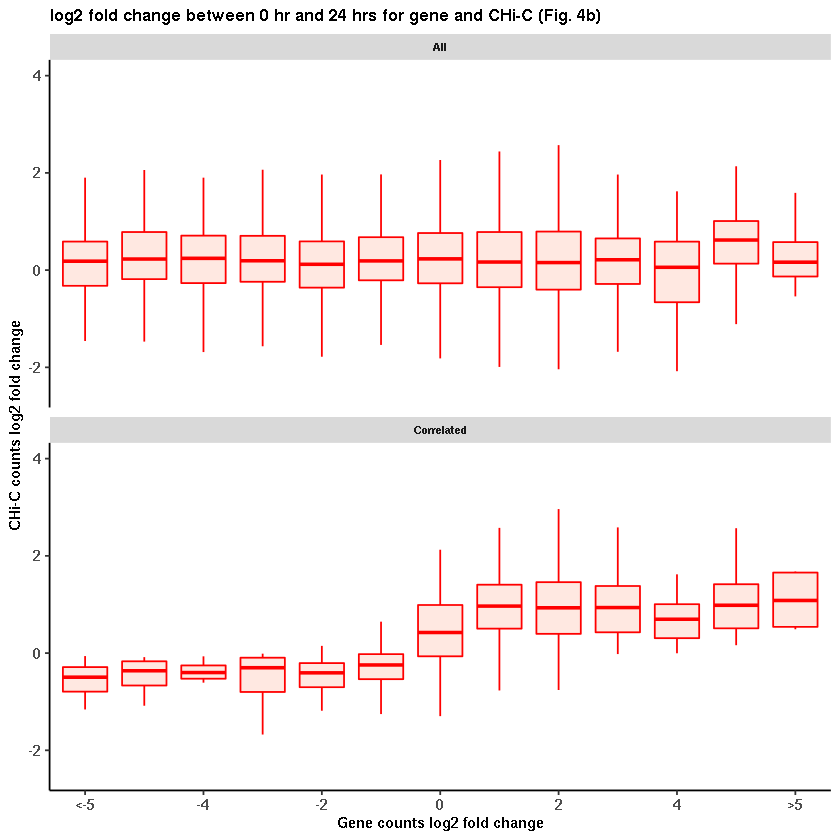

In [11]:
ggplot() + theme(panel.background=element_blank(), axis.line=element_line(), axis.text=element_text(size=8),axis.title=element_text(size=8,face="bold"), 
                       legend.position='NONE', plot.title=element_text(size=10, face='bold'), text=element_text(size=6, face='bold'),strip.text.x=element_text(siz=6, face='bold')) + 
geom_boxplot(data=data_forplot, aes(x=factor_gene_log2foldchange, 
                                                     y= chic_log2foldchange, fill="CHiC"),
                        outlier.shape = NA, color="red", alpha=0.2)+  
ylim(c(-2.5,4)) + xlab('Gene counts log2 fold change')  + ylab('CHi-C counts log2 fold change') +
  scale_colour_manual(name="",values=cols) + scale_fill_manual(name="",values=cols) +
scale_x_discrete(breaks=c("-6","-4","-2","0","2","4","6"),
        labels=c("<-5","-4","-2","0","2","4", ">5")) + 
ggtitle('log2 fold change between 0 hr and 24 hrs for gene and CHi-C (Fig. 4b)') + 
facet_wrap(.~label, ncol=1)

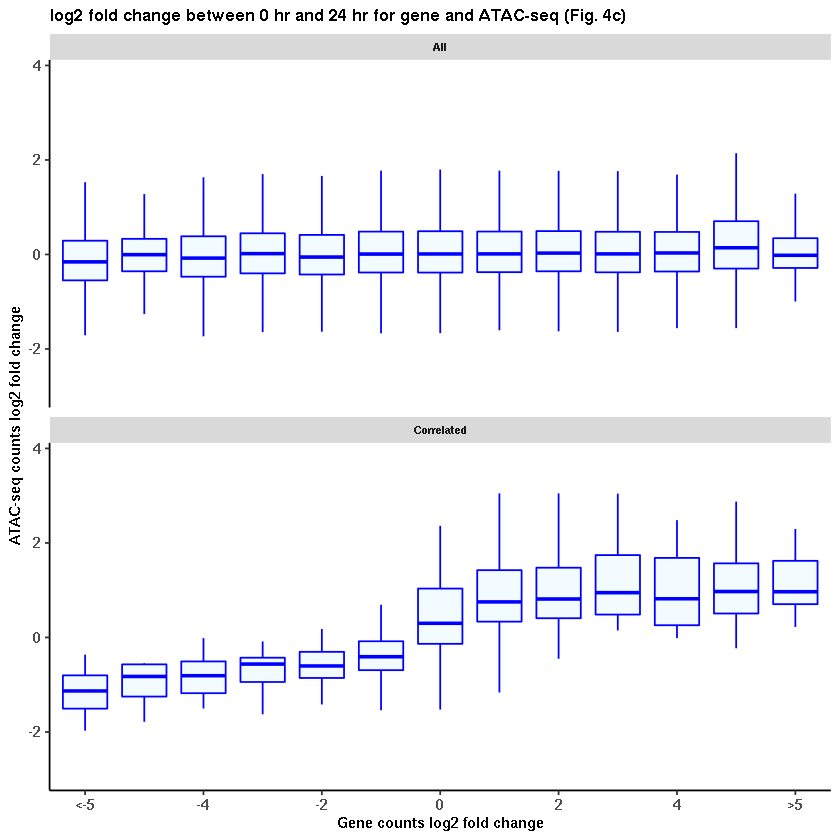

In [12]:
ggplot() + theme(panel.background=element_blank(), axis.line=element_line(), axis.text=element_text(size=8),axis.title=element_text(size=8,face="bold"), 
                       legend.position='NONE', plot.title=element_text(size=10, face='bold'), text=element_text(size=6, face='bold'),strip.text.x=element_text(siz=6, face='bold')) + 
geom_boxplot(data=data_forplot_atacseq, aes(x=factor_gene_log2foldchange, y=atacseq_log2foldchange, fill="ATAC-seq"),
                        outlier.shape = NA, color="blue", alpha=0.2 )+  
xlab('Gene counts log2 fold change')  + ylab('ATAC-seq counts log2 fold change') +
  scale_colour_manual(name="",values=cols_gene) + scale_fill_manual(name="",values=cols_gene) +
scale_x_discrete(breaks=c("-6","-4","-2","0","2","4","6"),
        labels=c("<-5","-4","-2","0","2","4", ">5")) + 
ggtitle('log2 fold change between 0 hr and 24 hr for gene and ATAC-seq (Fig. 4c)') + 
facet_wrap(.~label, ncol=1)